In [1]:
import pandas as pd
from ftfy import fix_text
from sklearn.metrics import f1_score
import re
import json
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
df = pd.read_csv('./gemini-2.0-flash.csv')

In [2]:
df1 = pd.read_csv('gemini-2.5-flash-preview-05-20_2.csv')
df2 = pd.read_csv('gemini-2.5-flash-preview-05-20_3.csv')
df = pd.concat([df1, df2], ignore_index=True)

In [3]:
#labels = ['Contradiction', 'Entailment', 'Unverifiable']
labels = ['Opposite meaning','Misrepresentation','Related but unverifiable','Entailment','Entity error','Unrelated and unverifiable','Numeric error','Missing information']
df = df.dropna()
# Hàm xử lý từng dòng
def extract_label(text):
    found = [label for label in labels if label in text]
    if len(found) == 1:
        return found[0]
    else:
        return 'MULTI_OR_NONE'  # đánh dấu các mẫu không rõ ràng

# Áp dụng hàm
df['predict'] = df['predict'].apply(extract_label)
df_ambiguous = df[df['predict'] == 'MULTI_OR_NONE']
df = df[df['predict'] != 'MULTI_OR_NONE']
print(len(df_ambiguous) == 0)
print(set(df['labels']) == set(df['predict']))
print(len(df))
macro_f1 = f1_score(df['labels'], df['predict'], average='weighted')
print("Macro F1 Score:", macro_f1)

False
True
3584
Macro F1 Score: 0.6347339655817906


In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Lấy giá trị thực và dự đoán
y_true = df['labels']
y_pred = df['predict']

# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(df['labels'].unique()))
labels = sorted(df['labels'].unique())  # Lấy danh sách nhãn theo thứ tự tăng

# Cấu hình kích thước và kiểu đồ họa
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Phóng to font chữ
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)

# Ghi chú trục
plt.xlabel('Predicted labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

# Căn chỉnh và lưu hình ảnh
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)  # Lưu ra file PNG độ phân giải cao
plt.close()  # Đóng figure để tránh hiển thị nếu dùng notebook
plt.show()

In [30]:
report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(report)


Classification Report:
                            precision    recall  f1-score   support

                Entailment       0.82      0.64      0.72      1328
              Entity error       0.54      0.78      0.64       174
         Misrepresentation       0.40      0.48      0.43       395
       Missing information       0.00      0.00      0.00        59
             Numeric error       0.83      0.83      0.83       115
          Opposite meaning       0.64      0.96      0.77       623
  Related but unverifiable       0.61      0.45      0.52       738
Unrelated and unverifiable       0.50      0.51      0.50       152

                  accuracy                           0.64      3584
                 macro avg       0.54      0.58      0.55      3584
              weighted avg       0.66      0.64      0.63      3584



Macro F1-score: 0.7233130370504178


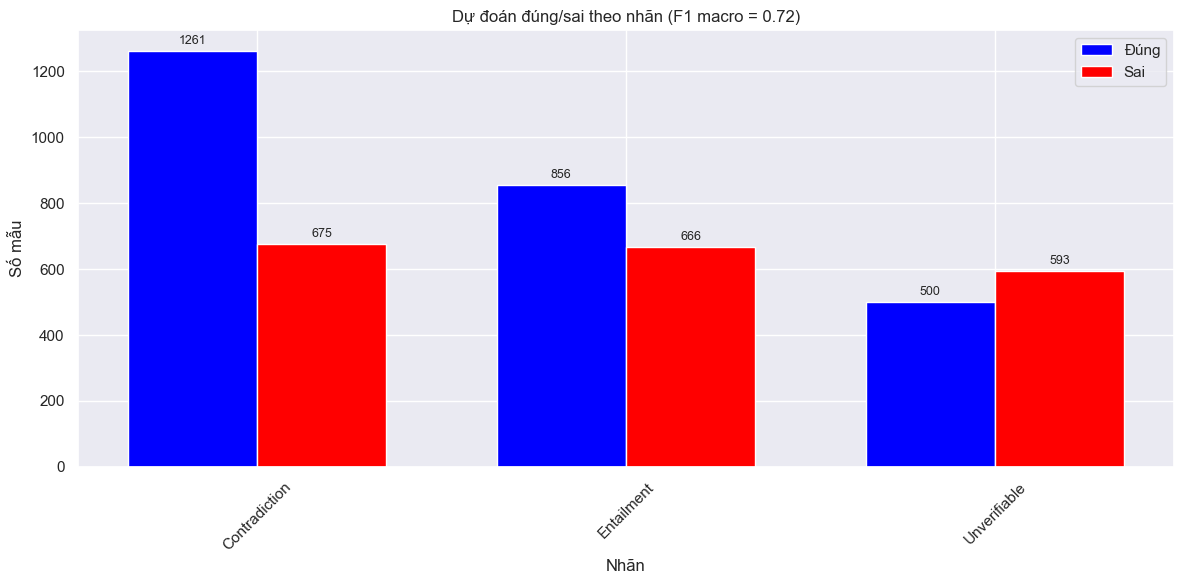

In [6]:
mapping = {
    'Entailment': 'Entailment',
    'Related but unverifiable': 'Unverifiable',
    'Unrelated and unverifiable': 'Unverifiable',
    'Opposite meaning': 'Contradiction',
    'Missing information': 'Contradiction',
    'Entity error': 'Contradiction',
    'Misrepresentation': 'Contradiction',
    'Numeric error': 'Contradiction'
}

# Áp dụng mapping vào cột 'predict'
df['predict'] = df['predict'].map(mapping)

f1 = f1_score(df['label'], df['predict'], average='weighted')
print("Macro F1-score:", f1)
labels = sorted(df['label'].unique())  # đảm bảo sắp xếp để hiển thị gọn
correct_counts = []
incorrect_counts = []

for label in labels:
    # Số lần dự đoán đúng cho nhãn này
    correct = ((df['label'] == label) & (df['predict'] == label)).sum()
    # Số lần dự đoán sai mà thực tế là nhãn này hoặc dự đoán thành nhãn này
    incorrect = ((df['label'] == label) & (df['predict'] != label)).sum() + \
                ((df['label'] != label) & (df['predict'] == label)).sum()
    
    correct_counts.append(correct)
    incorrect_counts.append(incorrect)

x = np.arange(len(labels))  # vị trí của nhãn
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, correct_counts, width, label='Đúng', color='blue')
bars2 = ax.bar(x + width/2, incorrect_counts, width, label='Sai', color='red')

ax.set_xlabel('Nhãn')
ax.set_ylabel('Số mẫu')
ax.set_title(f'Dự đoán đúng/sai theo nhãn (F1 macro = {f1:.2f})')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='x', labelrotation=45)
ax.legend()

# 🔢 Ghi số lên cột
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # khoảng cách so với đầu cột
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("ten_file.png")
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Lấy giá trị thực và dự đoán
y_true = df['label']
y_pred = df['predict']

# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(df['label'].unique()))
labels = sorted(df['label'].unique())  # Lấy danh sách nhãn theo thứ tự tăng

# Cấu hình kích thước và kiểu đồ họa
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Phóng to font chữ
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)

# Ghi chú trục
plt.xlabel('Predicted labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

# Căn chỉnh và lưu hình ảnh
plt.tight_layout()
plt.savefig("confusion_matrix1.png", dpi=600)  # Lưu ra file PNG độ phân giải cao
plt.close()  # Đóng figure để tránh hiển thị nếu dùng notebook
plt.show()

In [41]:
report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(report)


Classification Report:
               precision    recall  f1-score   support

Contradiction       0.69      0.92      0.79      1366
   Entailment       0.82      0.64      0.72      1328
 Unverifiable       0.71      0.56      0.63       890

     accuracy                           0.73      3584
    macro avg       0.74      0.71      0.71      3584
 weighted avg       0.74      0.73      0.72      3584

